In [1]:
from PIL import Image
import torch
import pickle
torch.set_printoptions(sci_mode=False)
from torchvision import transforms
from glob import glob
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np


In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Dino")
from dino_utils import dino_processor, setup_dino_model
os.chdir(current_wd)

Using mps as device
Using mps as device
Using mps as device


In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def plot_from_latent(latent):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    return tensor2im(gen.squeeze(0))

## 1. Setup Models

In [6]:
sku = 'SOA21C0KG-J11'
#sku = "02R21C014-Q11"
attribute = 'sleeve_length'

### 1.1. Dino Model

In [7]:
device = torch.device('cpu')
dino_model = setup_dino_model(device)

# Freeze the model
for param in dino_model.parameters():
    param.requires_grad = False

### 1.2. Generator Model
- Either hyperstyle or PTI

In [8]:
os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(current_wd)


G_PTI, latent = load_pti(sku)

# Freeze and set to eval
G_PTI.eval()
for param in G_PTI.parameters():
    param.requires_grad = False

# Send to CPU
G_PTI = G_PTI.to(device)
latent = latent.to(device)

### 1.3. Classifier Model

In [9]:
classifier_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{attribute}_pti_embeddings.pt"
model = torch.load(classifier_path, map_location = 'cpu').to(device)

softmax = torch.nn.Softmax(dim=1)

# Freeze and set to eval
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Load id2label dict
id2label = pickle.load(open(f"{ROOT_PATH}/4_Assessor/Dino/id2label_dicts/{attribute}_id2label.pkl", "rb"))
id2label

{0: 'Long',
 1: 'Short',
 2: 'Sleeveless',
 3: '3/4 length',
 4: 'Spaghetti straps',
 5: 'Extra short',
 6: 'Elbow length',
 7: 'Extra long',
 8: 'Mixed',
 9: 'Strapless',
 10: 'Sleeveless, strapless'}

### 1.4. Discriminator Mode

In [11]:
os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
# Load model architecture
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    D = architecture['D']
os.chdir(current_wd)

In [12]:
# Freeze and set to eval
D.eval()
for param in D.parameters():
    param.requires_grad = False

# Send to CPU
D = D.to(torch.device('cpu'))

## 2. Test Functioning of the components

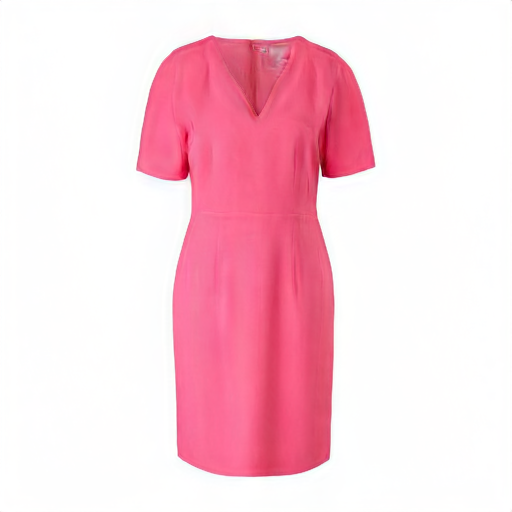

In [13]:
gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
tensor2im(gen.squeeze(0))

In [14]:
dino_input = dino_processor(gen)
dino_output = dino_model(dino_input)
classifier_output = model(dino_output)
scores = softmax(classifier_output)

# Merge scores with id2label
scores_dict = {id2label[key]: np.round(value,2) for key, value in enumerate(scores.squeeze().tolist())}
scores_dict

{'Long': 0.0,
 'Short': 0.95,
 'Sleeveless': 0.0,
 '3/4 length': 0.0,
 'Spaghetti straps': 0.0,
 'Extra short': 0.0,
 'Elbow length': 0.05,
 'Extra long': 0.0,
 'Mixed': 0.0,
 'Strapless': 0.0,
 'Sleeveless, strapless': 0.0}

### Test some Manipulations

In [15]:
latent_orig = latent.clone()
latent_orig.requires_grad = True

In [16]:
target_class = 0
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam([latent_orig], lr=1e-2)

  0%|          | 0/10 [00:00<?, ?it/s]

Step: 0 Target score: 1.3364687134753694e-08 | Loss: 1.0


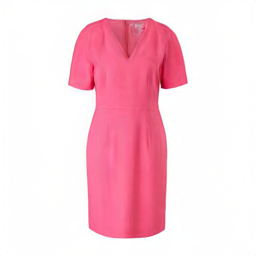

Step: 1 Target score: 9.337247774965363e-08 | Loss: 0.9999997615814209
Step: 2 Target score: 3.9099214177440444e-07 | Loss: 0.9999991655349731


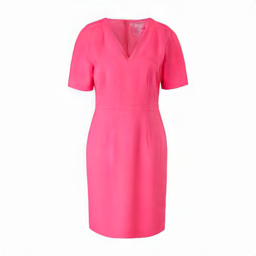

Step: 3 Target score: 8.164224851725521e-08 | Loss: 0.9999998807907104
Step: 4 Target score: 4.7591960594672855e-08 | Loss: 0.9999998807907104


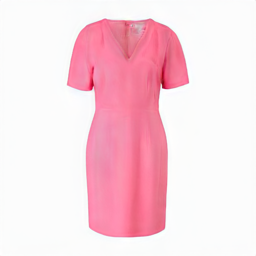

Step: 5 Target score: 1.498340118644137e-08 | Loss: 1.0
Step: 6 Target score: 1.0158275998151112e-08 | Loss: 1.0


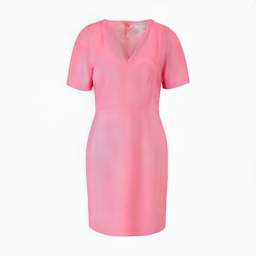

Step: 7 Target score: 1.2276629490770574e-08 | Loss: 1.0
Step: 8 Target score: 1.1691004608849198e-08 | Loss: 1.0


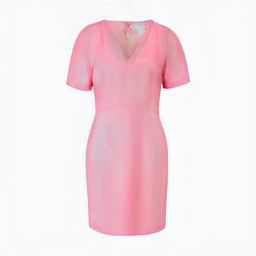

Step: 9 Target score: 1.0348007783989033e-08 | Loss: 1.0


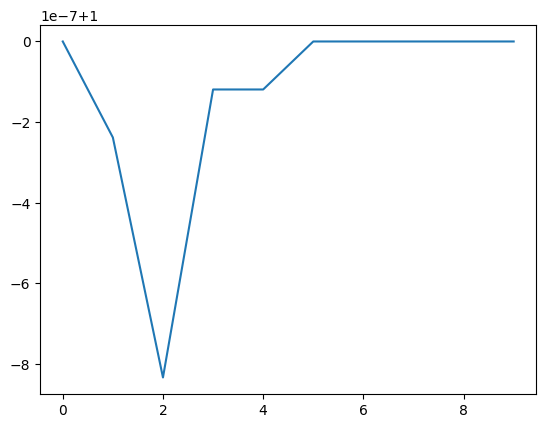

In [17]:
num_steps = 10

losses = []
for i in tqdm(range(num_steps), leave=False):
    optimizer.zero_grad()
    # Forward pass
    gen = G_PTI.synthesis(latent_orig, noise_mode='const', force_fp32=True)
    dino_input = dino_processor(gen)
    dino_output = dino_model(dino_input)
    classifier_output = model(dino_output)
    scores = softmax(classifier_output)
    target_score = scores[0, target_class]

    # Loss and backward pass
    loss = loss_fn(target_score, torch.tensor(1.0))
    loss.backward()
    print(f"Step: {i} Target score: {target_score.item()} | Loss: {loss.item()}")
    optimizer.step()
    losses.append(loss.item())

    if i % 2 == 0:
        display(tensor2im(gen.squeeze(0)).resize((256, 256)))

plt.plot(losses)

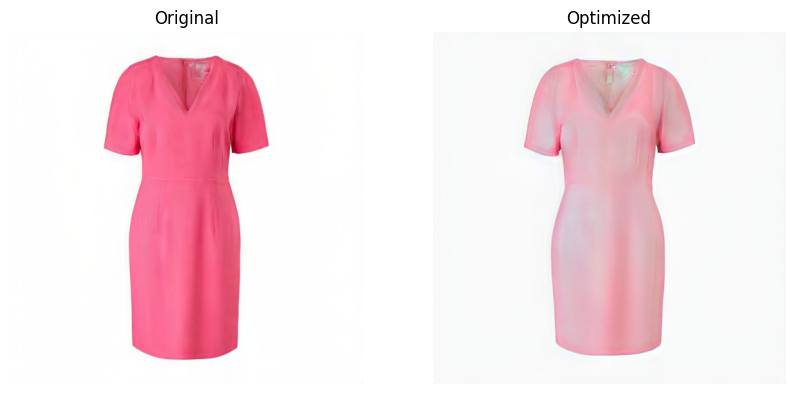

In [18]:
# Plot original
orig = plot_from_latent(latent)
# Plot optimized
optimized = plot_from_latent(latent_orig)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(orig)
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(optimized)
ax[1].set_title("Optimized")
ax[1].axis('off')
plt.show()

In [19]:
torch.nn.functional.cosine_similarity(latent.flatten(), latent_orig.flatten(), dim=0)

tensor(0.9996, grad_fn=<SumBackward1>)

### Test whether Generator is capable of diverse generations

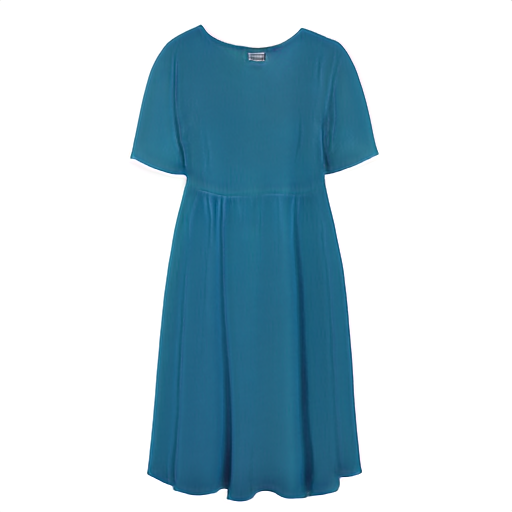

In [20]:
z = torch.randn(1, 512, device=device)

w = G_PTI.mapping(z, None)
img = G_PTI.synthesis(w, force_fp32=True, noise_mode='const')
tensor2im(img.squeeze(0))

### Test some other manipulations in latent space

In [21]:
def check_altering_dimensions(dimensions = [0, 1, 2, 3, 4, 5], num_samples = 10, scale_factor = 1.0):
    imgs = []

    for i in tqdm(range(num_samples)):
        latent_orig = latent.clone()
        disturbance = torch.randn(1, len(dimensions), 512, device=device) * scale_factor
        latent_orig[:, dimensions, :] = latent_orig[:, dimensions, :] + disturbance

        gen = G_PTI.synthesis(latent_orig, noise_mode='const', force_fp32=True)
        img = tensor2im(gen.squeeze(0))
        imgs.append(img)

    fig, ax = plt.subplots(2, 5, figsize=(15, 6))
    for i, img in enumerate(imgs):
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
    plt.suptitle(f"Effect of altering dimensions {dimensions} of the latent vector")
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

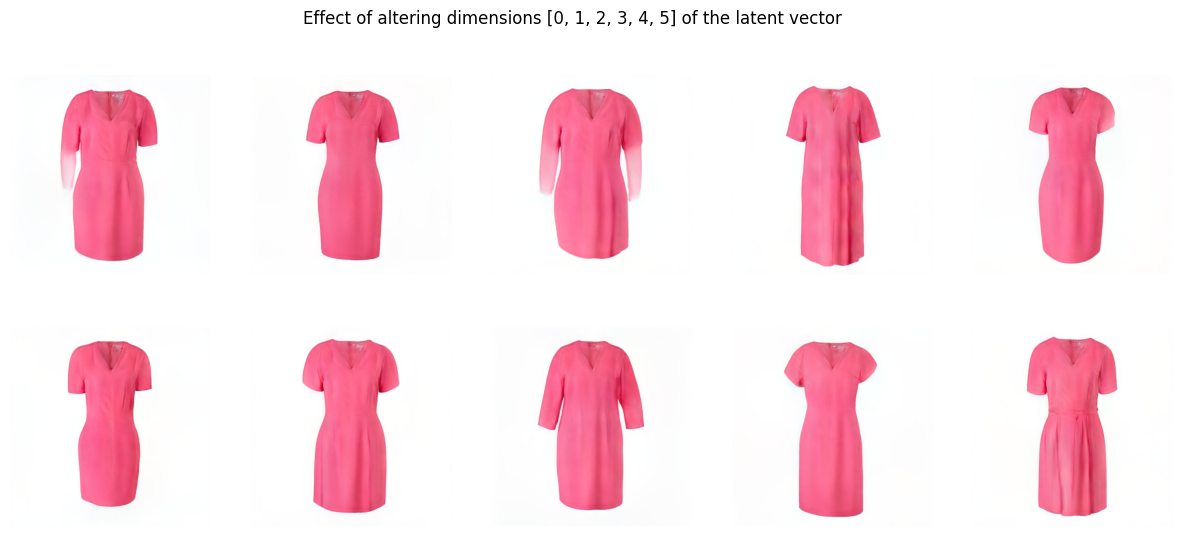

In [22]:
# Check effect of altering only the firts 6 dimensions of the latent vector
check_altering_dimensions(dimensions = [0, 1, 2, 3, 4, 5])

  0%|          | 0/10 [00:00<?, ?it/s]

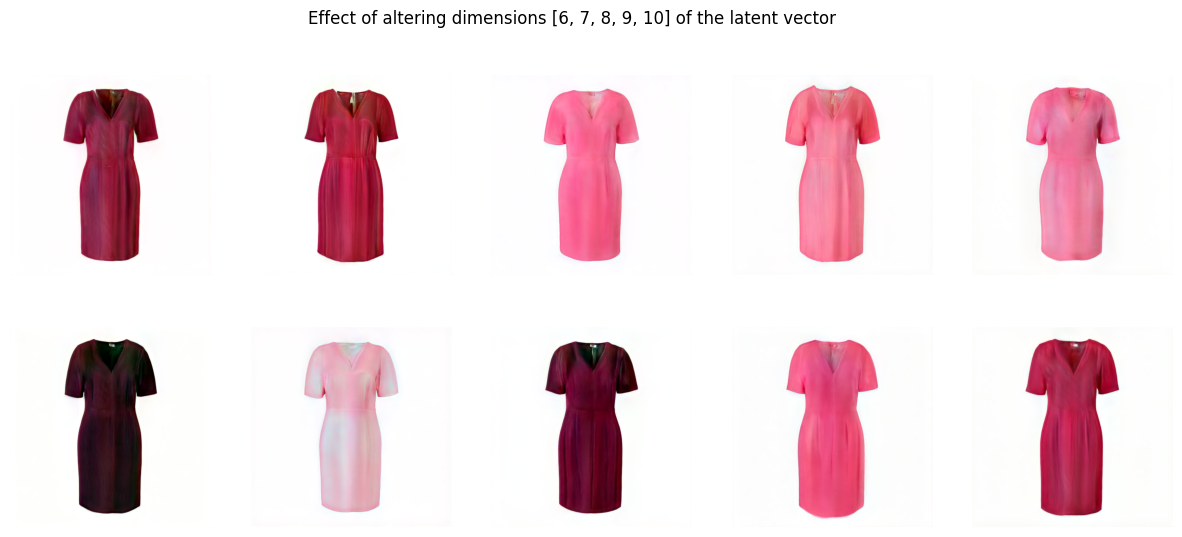

In [23]:
# Altering dimensions 7-11
check_altering_dimensions(dimensions = [6, 7, 8, 9, 10])

  0%|          | 0/10 [00:00<?, ?it/s]

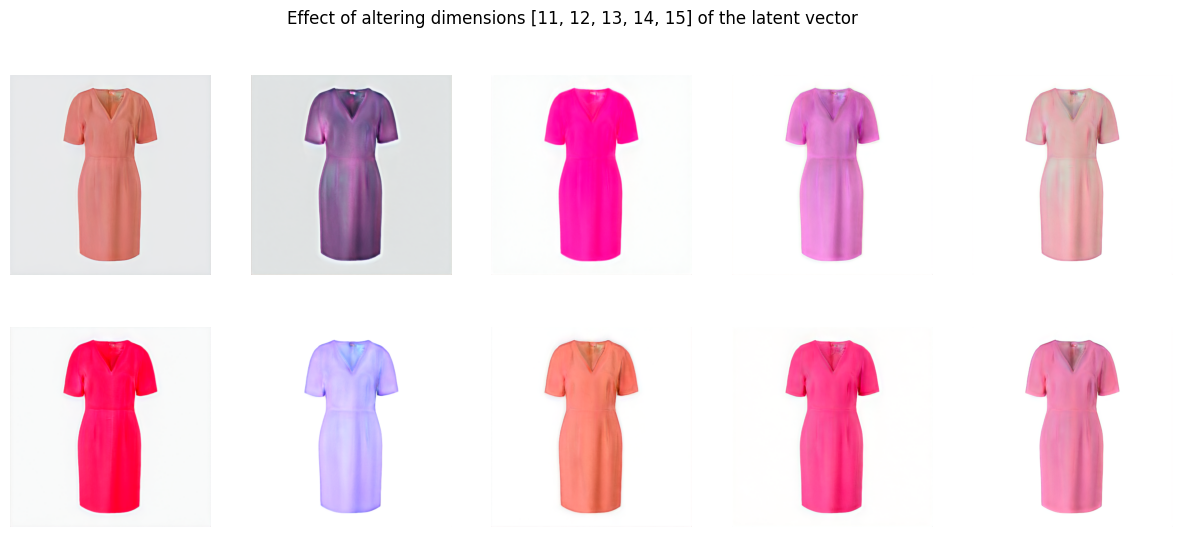

In [24]:
# Altering dimensions 12-16
check_altering_dimensions(dimensions = [11, 12, 13, 14, 15])

  0%|          | 0/10 [00:00<?, ?it/s]

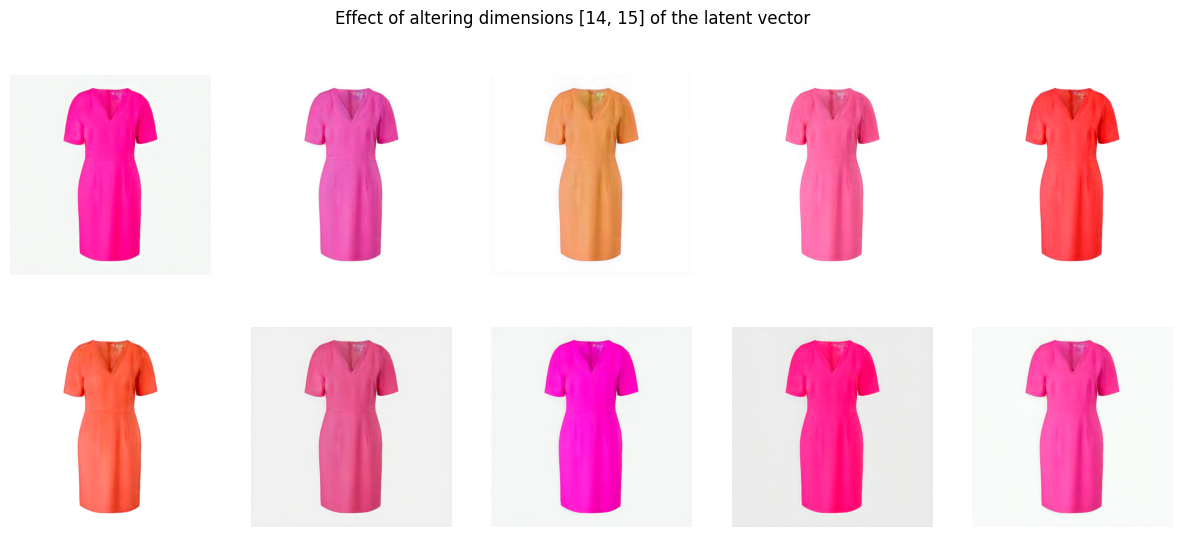

In [25]:
# Altering dimensions 13-16
check_altering_dimensions(dimensions = [14, 15])

  0%|          | 0/10 [00:00<?, ?it/s]

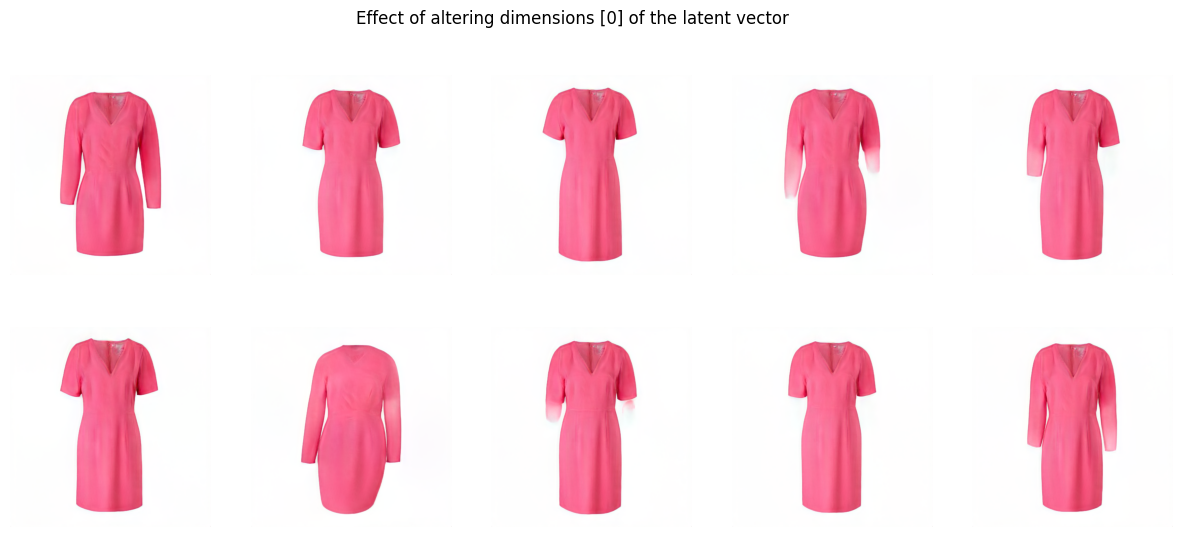

In [26]:
check_altering_dimensions(dimensions = [0], scale_factor = 3)

### Check PTI Generation with non-corresponding latent and generator

In [27]:
sku = "02R21C014-Q11"
alt_G_PTI, alt_latent = load_pti(sku)
alt_G_PTI = alt_G_PTI.to(device)
alt_latent = alt_latent.to(device)

In [30]:
# Load SG2 Ada Generator 
os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
# Load model architecture
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    sg2 = architecture['G_ema']
os.chdir(current_wd)

In [31]:
# Use first generator
g1_l1 = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
g1_l2 = G_PTI.synthesis(alt_latent, noise_mode='const', force_fp32=True)

# Use second generator
g2_l1 = alt_G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
g2_l2 = alt_G_PTI.synthesis(alt_latent, noise_mode='const', force_fp32=True)

# Use SG2Ada Generator
sg2_l1 = sg2.synthesis(latent, force_fp32=True, noise_mode='const')
sg2_l2 = sg2.synthesis(alt_latent, force_fp32=True, noise_mode='const')

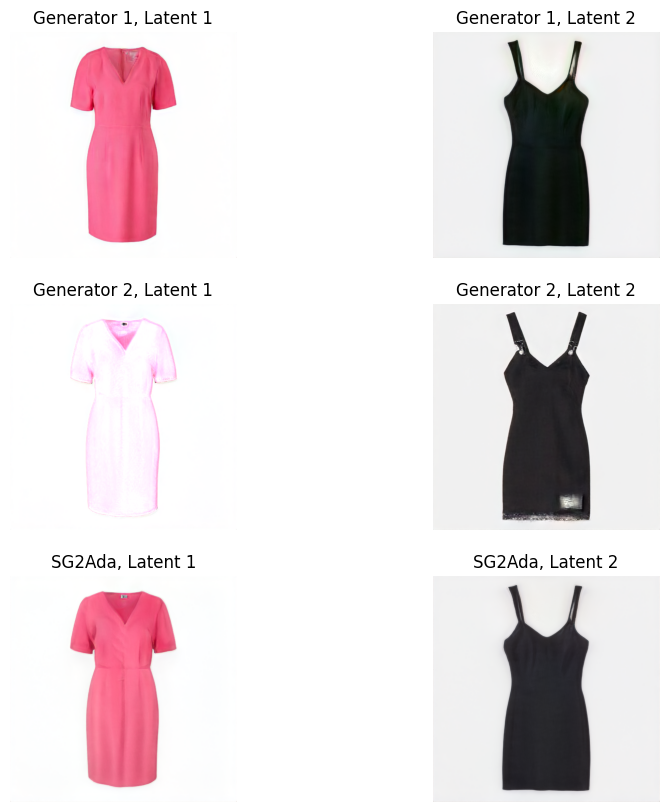

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0, 0].imshow(tensor2im(g1_l1.squeeze(0)))
ax[0, 0].set_title("Generator 1, Latent 1")
ax[0, 0].axis('off')

ax[0, 1].imshow(tensor2im(g1_l2.squeeze(0)))
ax[0, 1].set_title("Generator 1, Latent 2")
ax[0, 1].axis('off')

ax[1, 0].imshow(tensor2im(g2_l1.squeeze(0)))
ax[1, 0].set_title("Generator 2, Latent 1")
ax[1, 0].axis('off')

ax[1, 1].imshow(tensor2im(g2_l2.squeeze(0)))
ax[1, 1].set_title("Generator 2, Latent 2")
ax[1, 1].axis('off')

ax[2, 0].imshow(tensor2im(sg2_l1.squeeze(0)))
ax[2, 0].set_title("SG2Ada, Latent 1")
ax[2, 0].axis('off')

ax[2, 1].imshow(tensor2im(sg2_l2.squeeze(0)))
ax[2, 1].set_title("SG2Ada, Latent 2")
ax[2, 1].axis('off')

plt.show()

### Result: 
- Since the latent code does capture the overall dress characteristics when generating with the basis SG2Ada generator, one can use those latents or the generator weights to learn differences in classes. 
- To generate the final manipulated image, one can then still use PTI to also capture the fine details missing in the generic SG2Ada generation. 